# Statistical Analysis 

In [38]:
#Imports
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from matplotlib.pyplot import scatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import itertools
import pycountry_convert as pc
from scipy.stats import mannwhitneyu
from statistics import median
%matplotlib inline

In [39]:
path = '/home/karim/Downloads/Newmerged_data_2020.csv.gzip'  #Modify

In [40]:
df_quotes_chunks = pd.read_csv(path, chunksize = 40000, low_memory = False, compression='gzip')
samples = []
for i, chunk in enumerate(df_quotes_chunks):
    # get sample and append it to samples
    sample = chunk.sample(400)
    samples.append(sample)

In [41]:
sample = pd.concat(samples)
sample.drop_duplicates(inplace=True)
sample.reset_index()
sample.shape
sample.head(10)

,qid,Unnamed: 0_x,quoteID,quotation,speaker,prob,sentence_count,._per_sentence,",_per_sentence",!_per_sentence,...,union_ratio,other_ratio,sentiment,Unnamed: 0_y,date_of_birth,nationality,gender,occupation,academic_degree,religion
8629,Q10304982,1228603.0,2020-03-25-051316,Our lives have to go on. Jobs must be kept... ...,Jair Bolsonaro,0.6960,1,1.0,3.000000,0.0,...,1.000000,-1.000000,0.144,1439874,1955.0,Brazil,Male,Politics,NaN,Christian
24125,Q1058,2447468.0,2020-03-31-008277,"But unfortunately, their repeated messages on ...",Narendra Modi,0.7523,1,0.0,1.000000,0.0,...,0.000000,0.000000,0.227,7,1950.0,India,Male,Politics,NaN,Hindus
35116,Q1091159,1652512.0,2020-02-29-014840,"I think it's misleading, a lot of hitting inst...",Ron Roenicke,0.8214,1,1.0,4.000000,0.0,...,-1.000000,0.333333,-0.121,2341631,1956.0,United States of America,Male,Sports,NaN,NaN
35704,Q109232,1315102.0,2020-01-23-007943,"As one of the silence breakers, I stand in sol...",Rosanna Arquette,0.8476,2,1.0,1.000000,0.0,...,-0.333333,-1.000000,0.046,998226,1959.0,United States of America,Female,Arts,NaN,NaN
12960,Q1051086,1590894.0,2020-02-25-012149,"Do we all get excited about snippets? Yeah, bu...",Bud Black,0.7647,2,0.5,0.500000,0.0,...,1.000000,-1.000000,0.202,350684,1957.0,United States of America,Male,Sports,NaN,NaN
4432,Q10218,898680.0,2020-01-30-123895,Who knows what will happen tomorrow? If my goi...,Rahul Gandhi,0.9270,2,0.5,0.500000,0.0,...,-1.000000,-1.000000,0.000,1990848,1970.0,India,Male,Politics,NaN,Hindus
14796,Q10553748,256033.0,2020-02-03-097885,We were speaking about it at half time and we ...,Dele Alli,0.7198,3,1.0,0.333333,0.0,...,0.000000,-0.333333,0.050,2104994,1996.0,United Kingdom,Male,Sports,NaN,NaN
958,Q1000592,1307333.0,2020-02-17-060743,The fact of the matter is I believe I out-boxe...,Tyson Fury,0.7803,1,0.0,1.000000,0.0,...,-1.000000,-0.333333,0.306,1344809,1988.0,United Kingdom,Male,Other,NaN,Other
18324,Q1058,691682.0,2020-02-12-003952,All Governments hesitated to touch the tax sys...,Narendra Modi,0.8934,2,1.0,0.500000,0.0,...,-0.333333,-0.333333,0.010,7,1950.0,India,Male,Politics,NaN,Hindus
29711,Q1076161,2234003.0,2020-01-11-010195,Greg Maddux in a San Diego Padres camouflage u...,Dwight Gooden,0.8106,1,1.0,0.000000,0.0,...,0.000000,0.000000,0.000,2341250,1964.0,United States of America,Male,Sports,NaN,NaN


In [68]:
colors = ["#AD2646","#234473","#F4D7DB","#512E3B","#126EA8","#A76662","#D09790","#331F1C"]
custom_palette = sns.set_palette(sns.color_palette(colors))

import matplotlib.colors

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#234473"],
          [norm( 1.0), "#AD2646"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['font.weight'] = "semibold"

In [43]:
selected_feats = [',_per_sentence', '!_per_sentence','?_per_sentence','approx_word_count', 'token_count', 'adj_per_word', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio', 'pronoun_per_word', 'sentiment']
speaker_feats = ['date_of_birth', 'nationality', 'gender', 'occupation', 'academic_degree', 'religion']

In [44]:
def mean_boxplots(df,plot_by,features,order=None):
    """Plots the means of a given feature with respect to a given parameter.

    Keyword arguments:
    df -- dataframe to be analyzed
    plot_by -- list of parameters in string format to be compared
    features -- list of features in string format to be plotted
    """
    
    num = int(math.sqrt(len(features)))
    fig, axs = plt.subplots(num,num,figsize=(30, 15))
    for i,feat in enumerate(features):
        if i<num**2:
            x_idx = int(np.floor(i/num))
            y_idx = int(i%num)
            sns.boxplot(x=plot_by, y=feat, data=df, ax=axs[x_idx,y_idx], order=order,showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
        
    return

## Gender

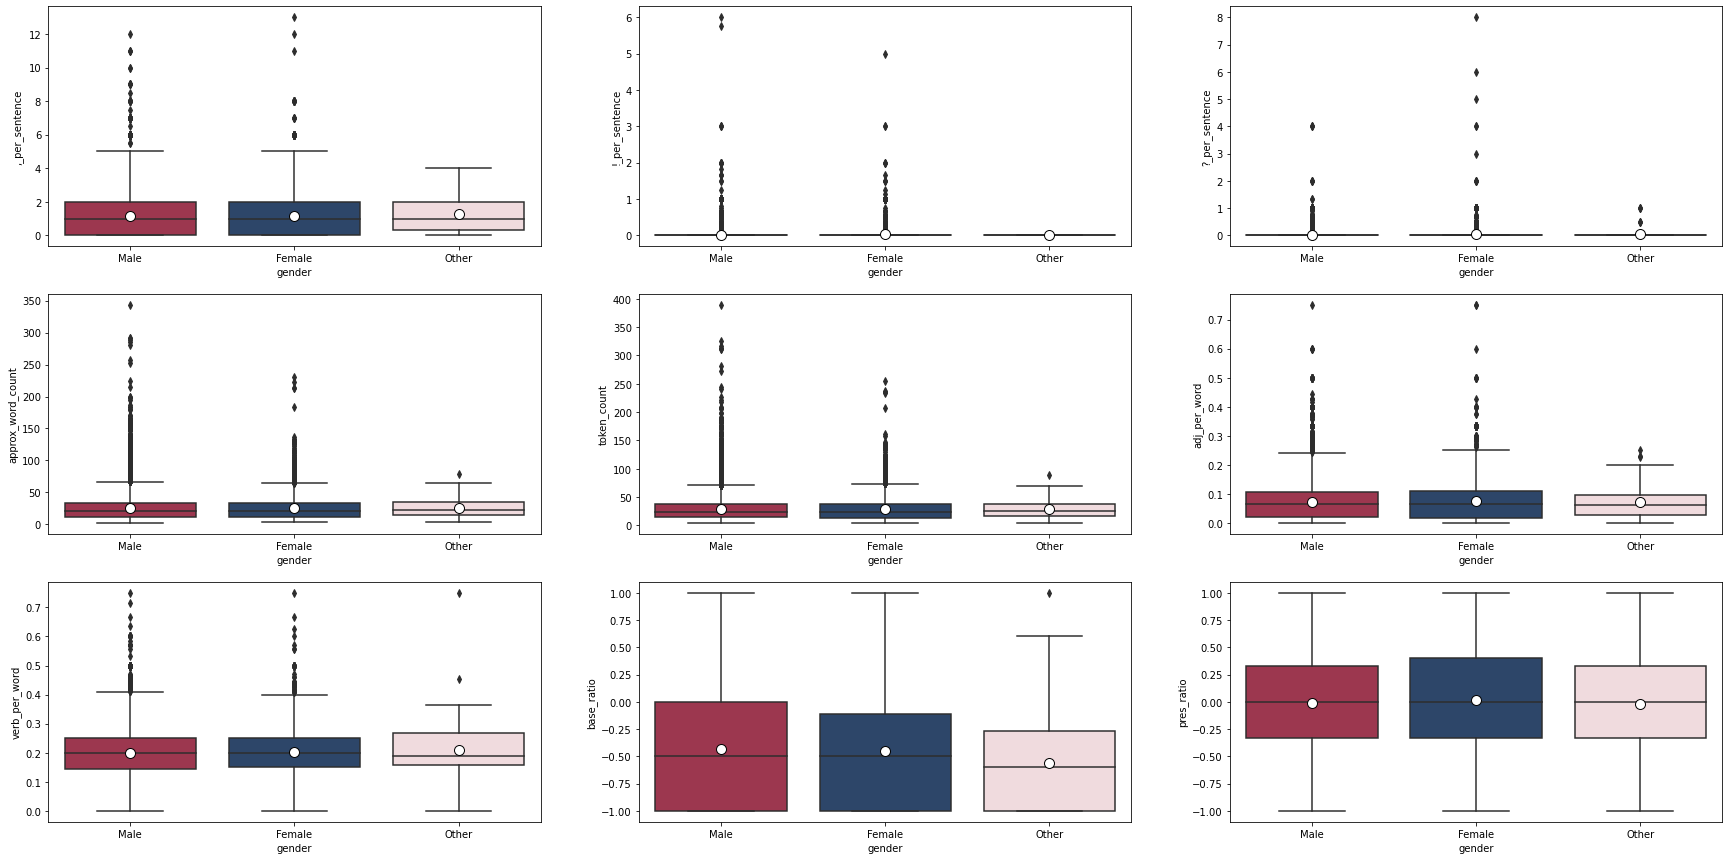

In [45]:
mean_boxplots(sample,plot_by='gender',features=selected_feats)

## Occupation

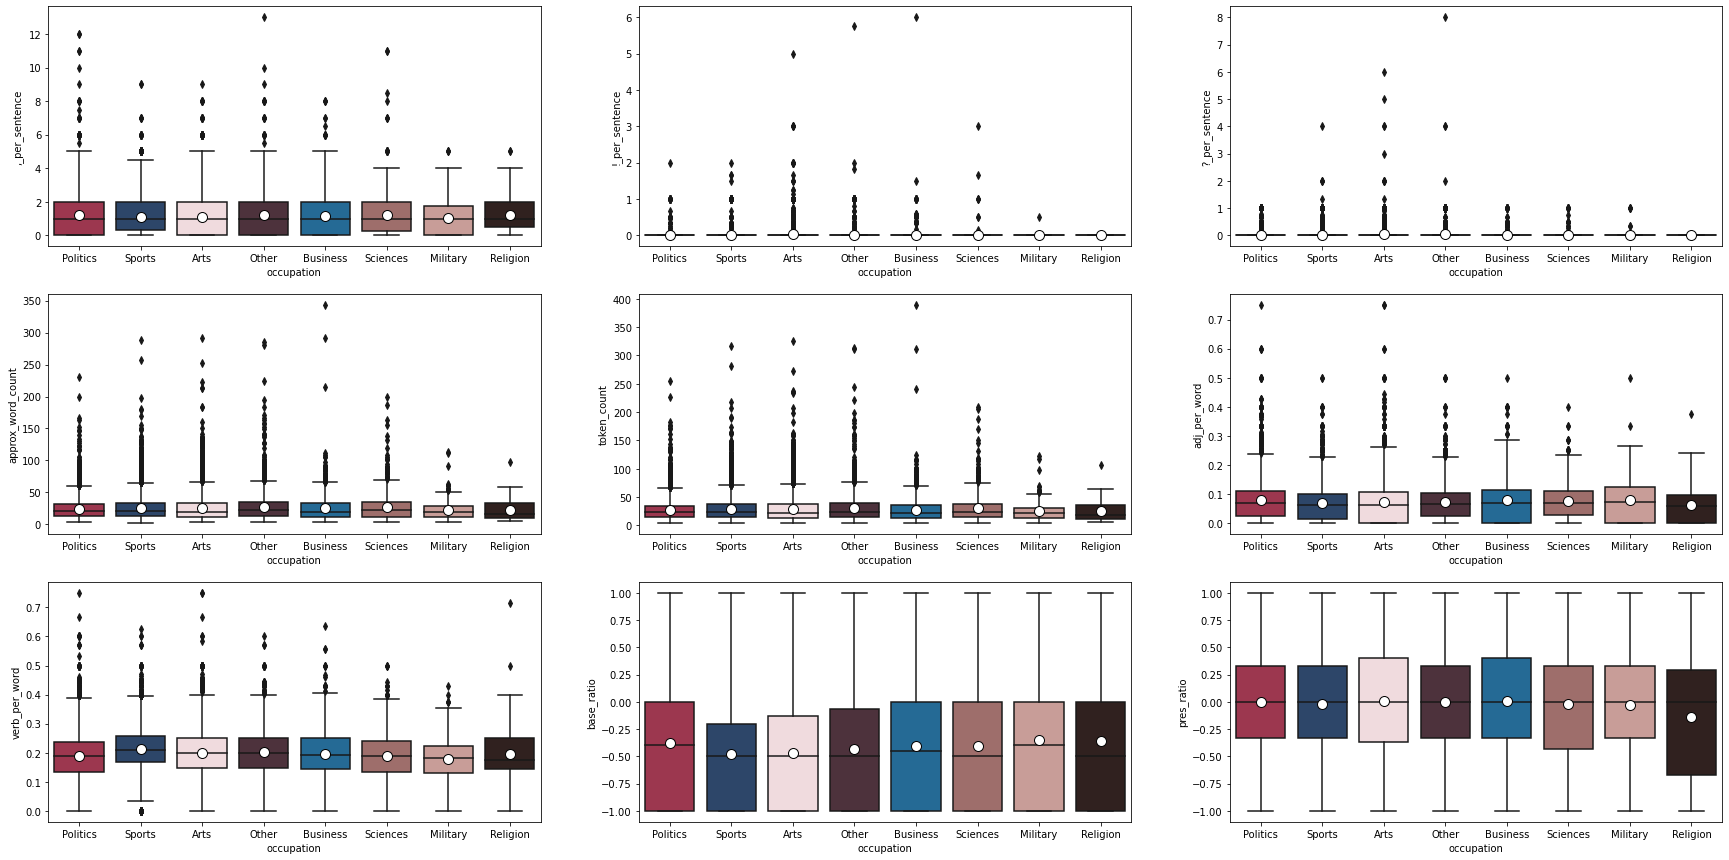

In [46]:
mean_boxplots(sample,plot_by='occupation',features=selected_feats)

## Academic Degree

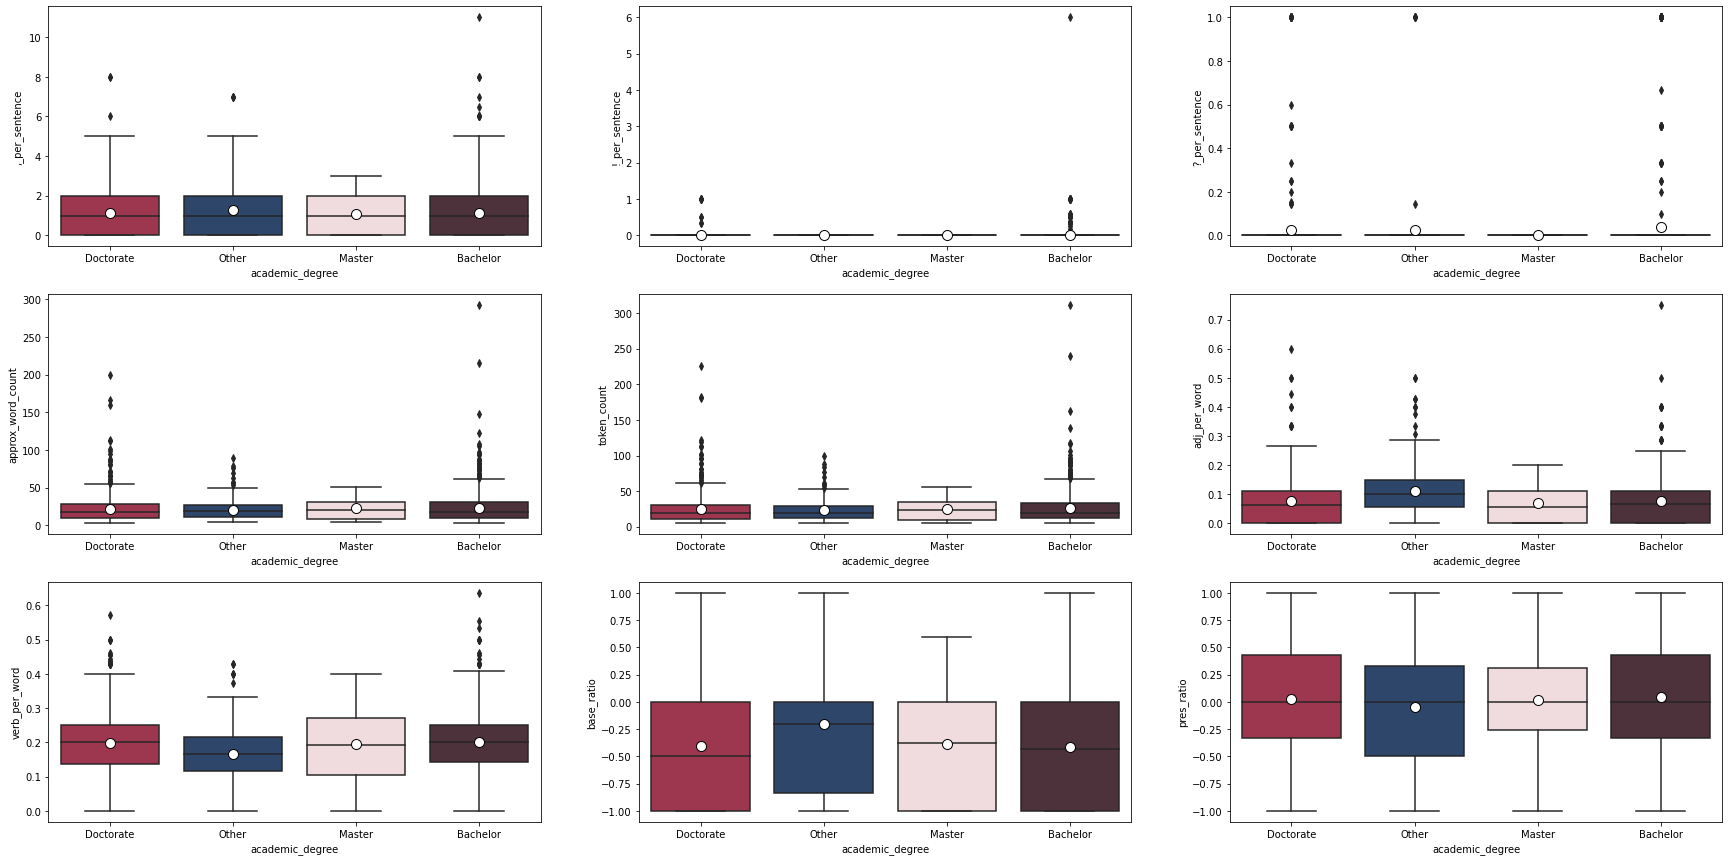

In [47]:
mean_boxplots(sample,plot_by='academic_degree',features=selected_feats)

## Religion

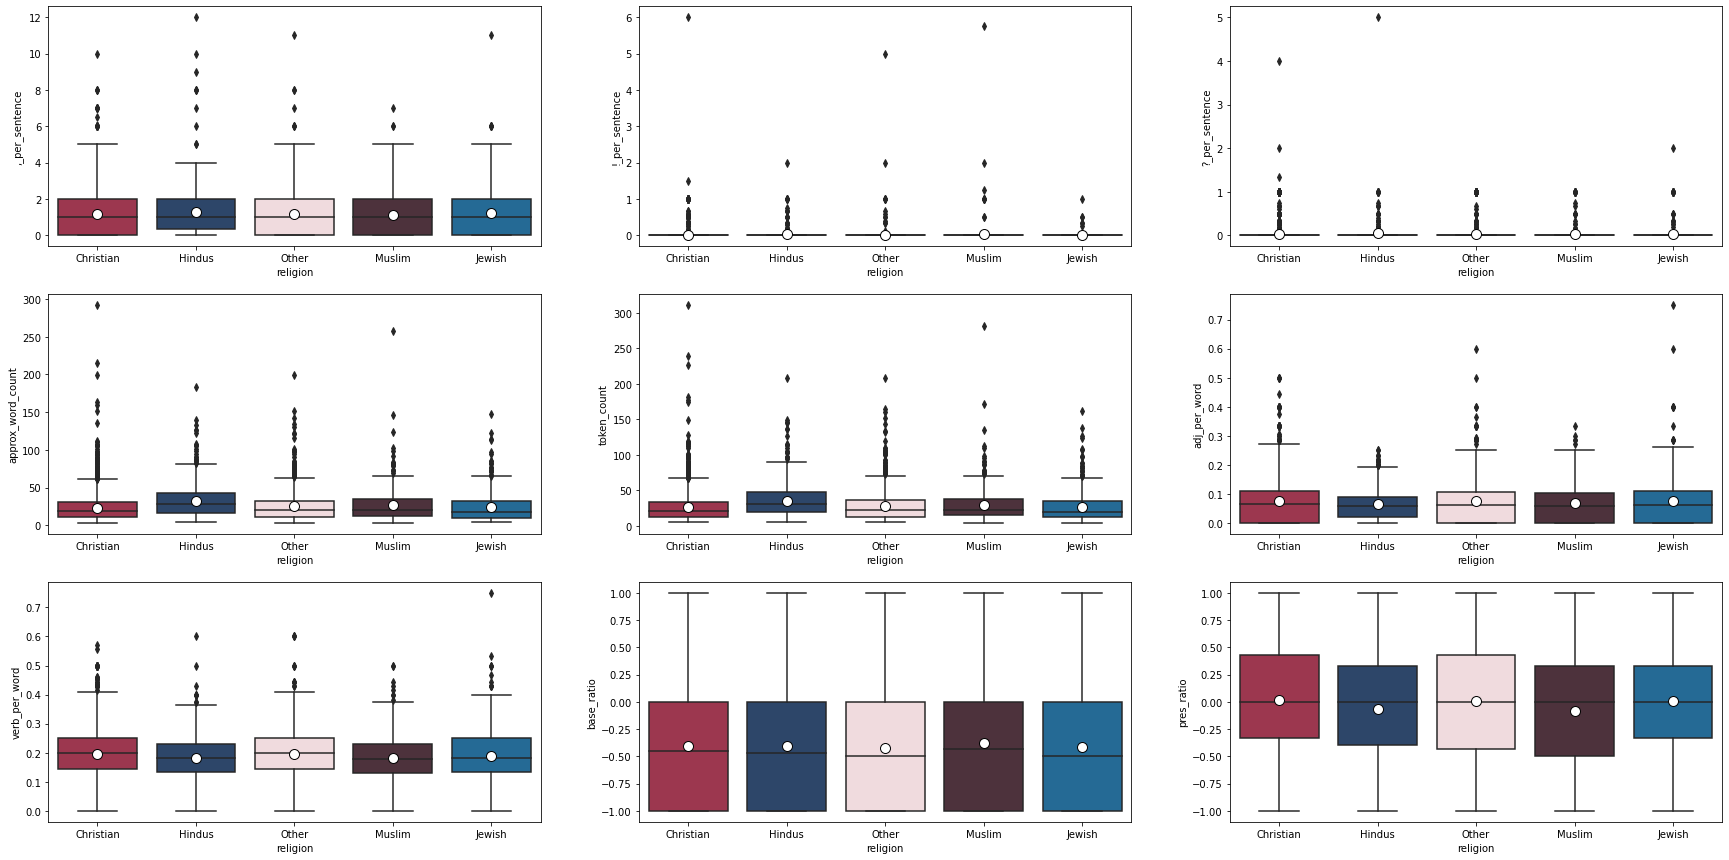

In [48]:
mean_boxplots(sample,plot_by='religion',features=selected_feats)

## Generation

In [49]:
def GroupBirthDates(sample):
    birth = sample.copy()
    birth["date_of_birth"] = birth["date_of_birth"].astype(int)
    birth["date_of_birth"] = birth["date_of_birth"].apply(lambda x: '30s' if x < 1940 else '50s' if x < 1960 else '70s' if x < 1980  else '90s' if x < 2000 else '00s' if x < 2020 else x)
    return birth

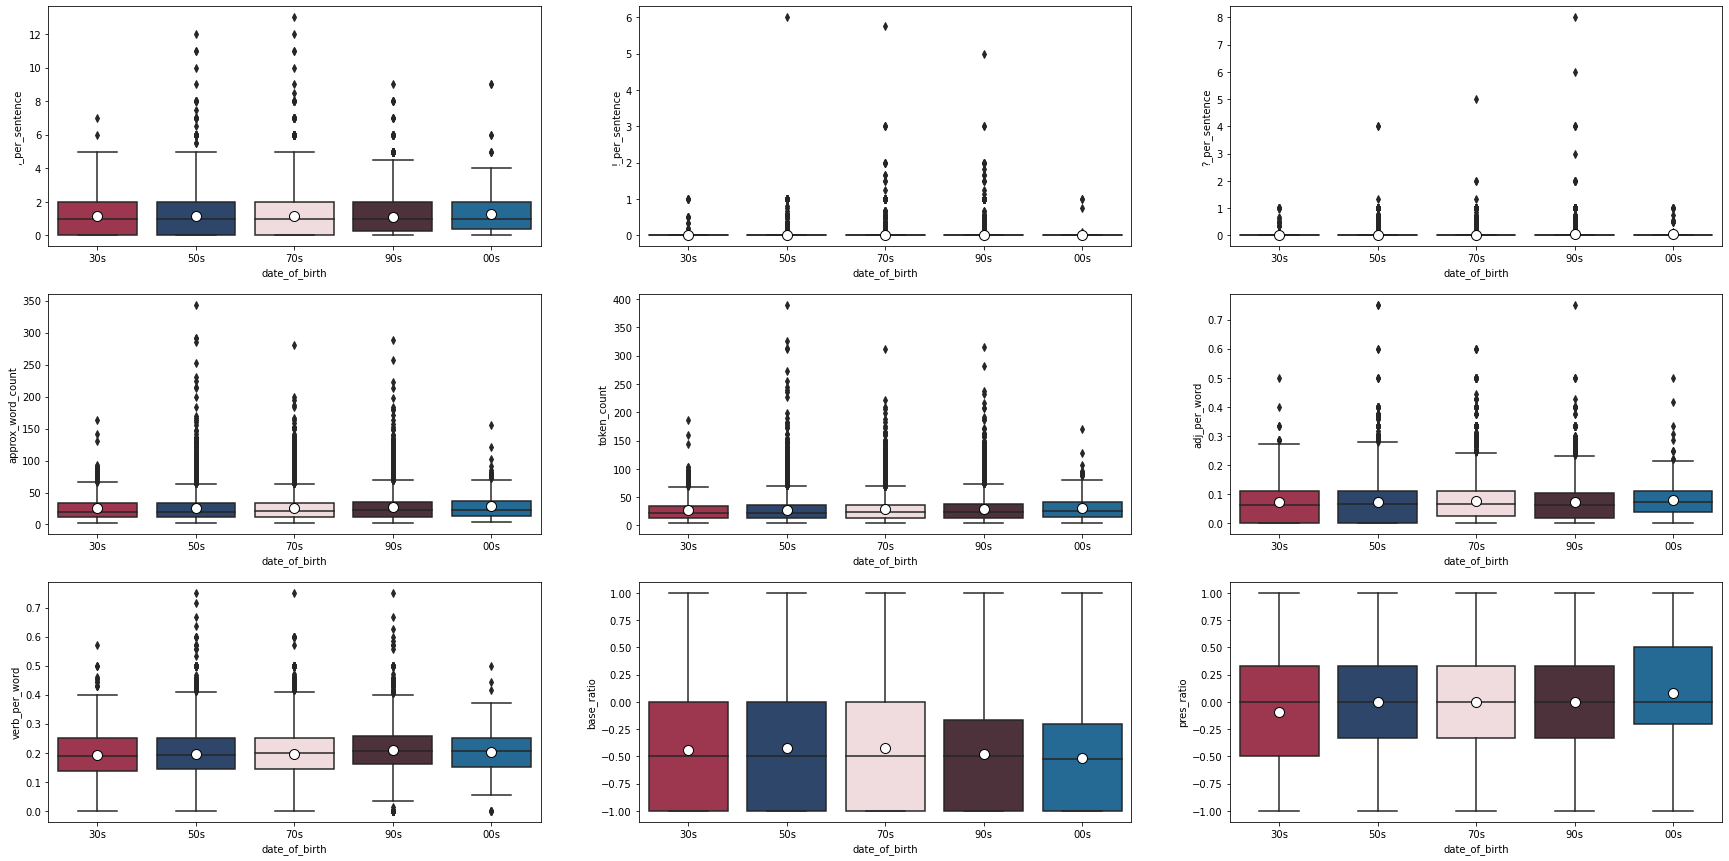

In [50]:
birth = GroupBirthDates(sample)
mean_boxplots(birth,plot_by='date_of_birth',features=selected_feats, order=["30s","50s","70s","90s","00s"])

## Continent

In [51]:
def GroupNationalities(sample):
    nat = sample.copy()
    for idx,i in enumerate(nat["nationality"]):
        try:
            nat["nationality"].iloc[idx] = pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(i, cn_name_format="default"))
        except:
            nat["nationality"].iloc[idx] = None
    return nat

/home/karim/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


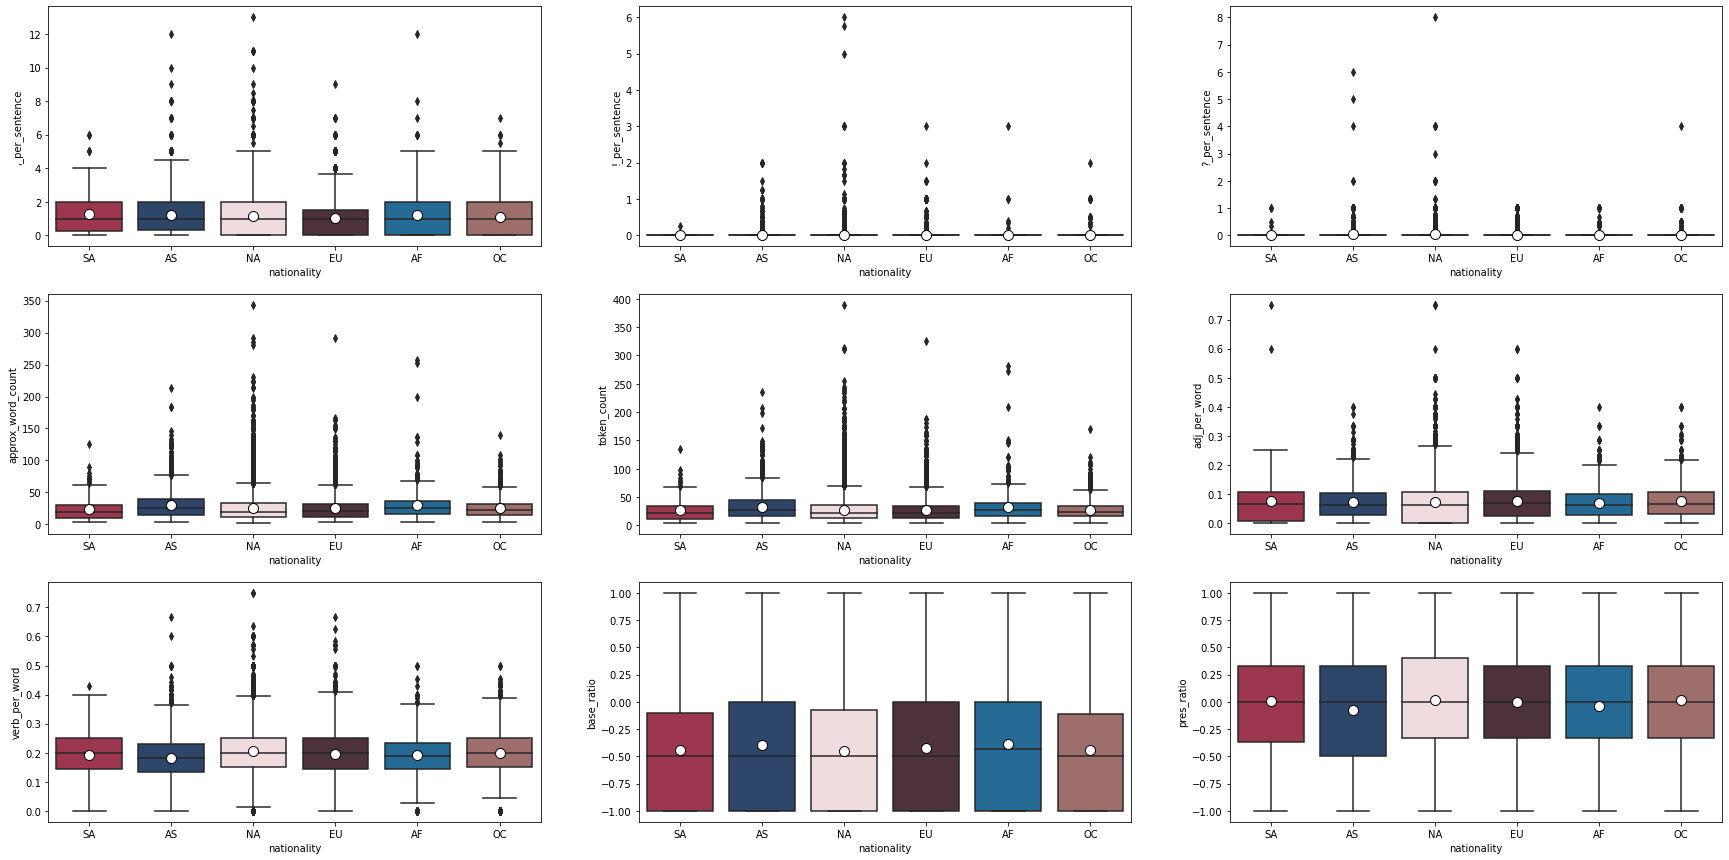

In [52]:
countries = GroupNationalities(sample)
mean_boxplots(countries,plot_by='nationality',features=selected_feats)

## Test the significance of the observed differences

In [53]:
def TestSignificance(df,lexical_features,speaker_features,tresh=0.05, verbose=False):
    Grid_max = np.zeros(shape=(len(lexical_features),len(speaker_features)))
    Grid_median = np.zeros(shape=(len(lexical_features),len(speaker_features)))
    for idx_i,i in enumerate(speaker_features):                                      #Iterate over
        for idx_j,j in enumerate(lexical_features):                                  #Iterate over
            unique = df[i].unique()                  #Iterate over the different attributes
            unique = unique[unique != np.array(None)]
            unique = np.array(unique, dtype=str)
            unique = unique[unique != 'nan']
            unique = unique[unique != 'Other']
            pairs = list(itertools.combinations(unique,2))
            min_p = 1
            res = []
            for k in pairs:
                try:
                    N, p = mannwhitneyu(df[df[i]==k[0]][j], df[df[i]==k[1]][j])
                    if p < min_p:
                        min_p = p
                        min_x = k[0]
                        min_y = k[1]
                        param = j
                        speak = i
                        Grid_max[idx_j,idx_i] = 1/min_p
                    res.append(p)   
                except:
                    print('Test failed for {},{}'.format(i,j))
            if verbose:
                print('The maximum statistically significant difference with {} in {} is between {} and {}'.format(j,i,k[0],k[1]))
                print('The p-value is {}'.format(min_p))
            Grid_median[idx_j,idx_i] = 1/median(res)
    return Grid_median, Grid_max, lexical_features, speaker_features

In [54]:
Test = sample.copy()
Test["date_of_birth"] = birth["date_of_birth"]
Test["nationality"] = countries["nationality"]
#selected_feats = ['sentence_count', 'approx_word_count','adj_per_word','verb_per_word', 'base_ratio', 'pres_ratio',
#       'past_ratio', 'pronoun_per_word', 'self_ratio', 'union_ratio',
#       'other_ratio', 'sentiment']
selected_feats = ['sentence_count', '._per_sentence', ',_per_sentence', '!_per_sentence',
       '?_per_sentence', ':_per_sentence', ';_per_sentence', 'sign_per_token',
       'punctuation_per_sentence', 'approx_word_count', 'token_count',
       'adj_per_word', 'ordinal_ratio', 'comparative_ratio',
       'superlative_ratio', 'verb_per_word', 'base_ratio', 'pres_ratio',
       'past_ratio', 'pronoun_per_word', 'self_ratio', 'union_ratio',
       'other_ratio', 'sentiment']
speaker_feats = ['date_of_birth','nationality', 'gender', 'occupation', 'academic_degree', 'religion']
Grid_mean, Grid_max, lexical_features, speaker_features = TestSignificance(Test,selected_feats,speaker_feats,verbose=True)

The maximum statistically significant difference with sentence_count in date_of_birth is between 30s and 00s
The p-value is 2.797034695099566e-19
The maximum statistically significant difference with ._per_sentence in date_of_birth is between 30s and 00s
The p-value is 0.0031715404846345903
The maximum statistically significant difference with ,_per_sentence in date_of_birth is between 30s and 00s
The p-value is 0.03397603771921789
The maximum statistically significant difference with !_per_sentence in date_of_birth is between 30s and 00s
The p-value is 1.2436789495296799e-11
The maximum statistically significant difference with ?_per_sentence in date_of_birth is between 30s and 00s
The p-value is 0.026308968512732494
The maximum statistically significant difference with :_per_sentence in date_of_birth is between 30s and 00s
The p-value is 0.010516772669459017
The maximum statistically significant difference with ;_per_sentence in date_of_birth is between 30s and 00s
The p-value is 0.0

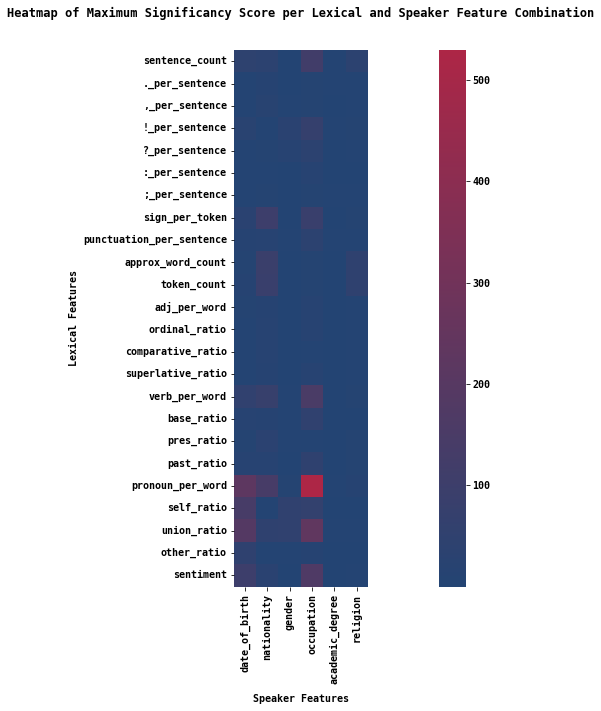

In [121]:
df = pd.DataFrame(data=np.log(Grid_max), index=selected_feats, columns=speaker_feats)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Maximum Significancy Score per Lexical and Speaker Feature Combination", fontweight='semibold', y=1.05)
plot = sns.heatmap(df, ax=ax, cmap=cmap, square=True)
plt.xlabel('Speaker Features', fontweight='semibold')
plt.ylabel('Lexical Features', fontweight='semibold')
ax.xaxis.set_label_coords(0.5, -0.2)
plt.tight_layout()
plt.show()
plot.get_figure().savefig("Max_Significancy_Score.png",dpi=300,bbox_inches="tight")

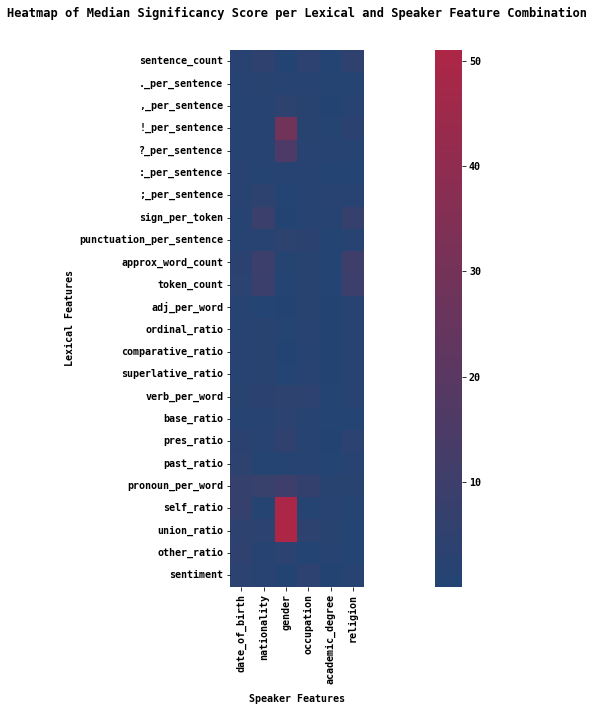

In [122]:
df = pd.DataFrame(data=np.log(Grid_mean), index=selected_feats, columns=speaker_feats)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Median Significancy Score per Lexical and Speaker Feature Combination", fontweight='semibold',y=1.05)
plot = sns.heatmap(df, ax=ax, cmap=cmap, square=True)
plt.xlabel('Speaker Features', fontweight='semibold')
plt.ylabel('Lexical Features', fontweight='semibold')
ax.xaxis.set_label_coords(0.5, -0.2)
plt.tight_layout()
plt.show()
plot.get_figure().savefig("Median_Significancy_Score.png",dpi=300,bbox_inches="tight")